In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
tqdm.pandas()
from scipy.spatial.distance import cosine
import numpy as np
_stopwords = stopwords.words('dutch')

In [13]:
c1 = pd.read_csv('dfs/c1.csv',index_col = 0)
c2 = pd.read_csv('dfs/c2.csv',index_col = 0)

In [3]:
def compare(df, vect):
    it = iter(range(1,len(df)))
    sims = [0]

    for i in tqdm(it):
        a = df.iloc[i]['text_y_cleaned']
        b = df.iloc[i-1]['text_y_cleaned']

        if pd.isnull(a):
            j = i
            skips = 1
            j+=1
            sims.append(0)

            while pd.isnull(df.iloc[j]['text_y_cleaned']):
                sims.append(0)
                j+=1
                skips+=1
            
            a = df.iloc[j]['text_y_cleaned']

            a = vect.transform([a]).todense()
            b = vect.transform([b]).todense()

            sims.append(1-(cosine(a,b)))

            for _ in range(skips):
                i = next(it)

        else:
            a = vect.transform([a]).todense()
            b = vect.transform([b]).todense()

            sims.append(1-(cosine(a,b)))

    return sims

In [4]:
corpus1 = c1[~c1['text_y_cleaned'].isnull()]['text_y_cleaned'].values
corpus2 = c2[~c2['text_y_cleaned'].isnull()]['text_y_cleaned'].values
corpus = np.append(corpus1, corpus2)
vect = TfidfVectorizer(stop_words = _stopwords)
vect1 = TfidfVectorizer(stop_words = _stopwords)
vect2 = TfidfVectorizer(stop_words = _stopwords)
vect1.fit(corpus1)
vect2.fit(corpus2)
vect.fit(corpus)

TfidfVectorizer(stop_words=['de', 'en', 'van', 'ik', 'te', 'dat', 'die', 'in',
                            'een', 'hij', 'het', 'niet', 'zijn', 'is', 'was',
                            'op', 'aan', 'met', 'als', 'voor', 'had', 'er',
                            'maar', 'om', 'hem', 'dan', 'zou', 'of', 'wat',
                            'mijn', ...])

## TFIDF fit on Corpus2, compared to i-1 with skips

In [15]:
c1['tfidf_sim'] = compare(c1, vect)
c1[['full_name','page','text_y_cleaned','tfidf_sim','label']].to_csv('sim_scores/tfidf_skip_c1.csv')

18116it [02:01, 149.22it/s]


## TFIDF fit on Corpus1, compared to i-1 with skips

In [16]:
c2['tfidf_sim'] = compare(c2, vect)
c2[['full_name','page','text_y_cleaned','tfidf_sim','label']].to_csv('sim_scores/tfidf_skip_c2.csv')

16294it [01:43, 158.15it/s]


# Eval

In [17]:
def change_format(y):
    y[0] = 1
    indices = [i for i, x in enumerate(y) if x == 1]+[len(y)-1]
    result = []
    for i in range(len(indices)):
        if i != len(indices)-1:
            result.append(indices[i+1] - indices[i])
    result[-1]+=1
    return result

In [18]:
def make_index(split):
    '''Turns a doc length vector like [1,2,1,3,3,5] into a dict with pagenumbers as keys and the set of all 
    pagenumbers in the same document as value.
    This thus is an index which gives for every page its cluster.'''
    l= sum(split)
    pages= list(np.arange(l))
    out = defaultdict(set)
    for block_length in split:
        block= pages[:block_length]
        pages= pages[block_length:]
        for page in block:
            out[page]= set(block)
    return out

In [19]:
def Bcubed(truth,pred):
    assert sum(truth)==sum(pred)  # same amount of pages
    truth,pred = make_index(truth), make_index(pred)
    
    df  ={i:{'size':len(truth[i]),'P':0,'R':0,'F1':0} for i in truth}
    for i in truth:
        df[i]['P']= len(truth[i] & pred[i])/len(pred[i]) 
        df[i]['R']= len(truth[i] & pred[i])/len(truth[i])
        df[i]['F1']= (2*df[i]['P']*df[i]['R'])/(df[i]['P']+df[i]['R'])
    df= pd.DataFrame.from_dict(df, orient='index')
    df.index_name='PageNr'
    return  df


def MeanBcubed(truth,pred):
    assert sum(truth)==sum(pred)  # same amount of pages
    return Bcubed(truth,pred).mean()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict

_c1 = c1[~pd.isnull(c1['text_y_cleaned'])]
_c2 = c2[~pd.isnull(c2['text_y_cleaned'])]

# Train on c2, predict c1

In [22]:
features = ['font_diff3','crop_diff','tfidf_sim']

X_train = c2[features]
y_train = c2['label']
X_test = c1[features]
y_test = c1['label']

model = LogisticRegression()

model.fit(X_train, y_train)

true = y_test
preds = model.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(model.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    34.380170
P        0.312589
R        0.938343
F1       0.349604
dtype: float64


(0.6102062975027145, 0.14358712314767502, 0.23247156153050672)

In [23]:
features = ['font_diff3','crop_diff','tfidf_sim']

X_train = _c2[features]
y_train = _c2['label']
X_test = _c1[features]
y_test = _c1['label']

model = LogisticRegression()

model.fit(X_train, y_train)

true = y_test
preds = model.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(model.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    34.403323
P        0.344392
R        0.944612
F1       0.388065
dtype: float64


(0.7188940092165899, 0.16305199895479489, 0.265814696485623)

# Train on c1, predict c2

In [24]:
features = ['font_diff3','crop_diff','tfidf_sim']

X_train = c1[features]
y_train = c1['label']
X_test = c2[features]
y_test = c2['label']

model = LogisticRegression()

model.fit(X_train, y_train)

true = y_test
preds = model.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(model.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    68.910383
P        0.435097
R        0.832891
F1       0.355189
dtype: float64


(0.4143884892086331, 0.27131417804992936, 0.32792485055508114)

In [25]:
features = ['font_diff3','crop_diff','tfidf_sim']

X_train = _c1[features]
y_train = _c1['label']
X_test = _c2[features]
y_test = _c2['label']

model = LogisticRegression()

model.fit(X_train, y_train)

true = y_test
preds = model.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(model.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    69.707824
P        0.523023
R        0.804469
F1       0.426743
dtype: float64


(0.4298941798941799, 0.313102119460501, 0.3623188405797102)

<AxesSubplot:>

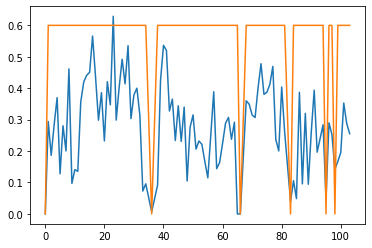

In [15]:
import matplotlib as plt

_c1['tfidf_sim'][:100].plot()
_c1['label'].apply(lambda x: 0 if x == 1 else .6)[:100].plot()

In [12]:
# import re
# for i in range(len(c1[['file_name','page','text_y','label']])):
#     display(re.sub('\n', ' ', _c1.iloc[i]['text_y']))
#     if i == 500:
#         break